In [179]:
import numpy as np

In [180]:
def dilser(low=0.001, limit=100.0, dilfactor = 2.0):
    """Returns a list containing a dilution series that ranges from
    "low" to "limit" by "dilfactor".
    """
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    
    return np.array(a)


In [181]:
lig = dilser()

a = np.delete(lig,[15,16])

b = np.delete(lig,[14,17])

c = np.delete(lig,[13,15])

ligset = np.array([lig,a,lig,b,c])

In [182]:
rtots = np.array([0.001,0.005, 0.01, 0.02, 0.05])

sim_parms = dict({'k11':3.7, 'k21':1.8, 'k22':0.12, 'l20':293.0})

parmvec = [3.7,1.8,0.12,293.0]

In [183]:
def wyman_sim_parmvec(parm,lig,rtot):
    """ Generates bound fraction for Wyman model given parameters and returns as 
    nested array simulated dataset  
    parm is a 1-D numpy array that must describe [k11,k21,k22,l20]
    lig is a 1-D array or 1-D array of 1-D arrays of ligand concentrations
    rtot is a 1-D numpy array of total receptor concentrations for each data set
    size of rtot and lig must match 
    """
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    holder = []
    
    for i in range(lig.size):
        rfree = (((-1 - k11*lig[i]) + \
        (np.sqrt((1 + k11*lig[i])**2 + 8*l20*rtot[i]*(1 + k21*lig[i] + \
        k21*k22*(lig[i]**2)))))/(4*l20*(1 + k21*lig[i] + k21*k22*(lig[i]**2))))
        
        bfrac = (k11*lig[i] + l20*k21*rfree*lig[i] + \
        2*l20*k21*k22*rfree*(lig[i]**2))/(1 + 2*l20*rfree + k11*lig[i] + \
        2*l20*k21*rfree*lig[i] + 2*l20*k21*k22*rfree*(lig[i]**2))
        
        holder.append(bfrac)
        
    return np.array(holder)

In [184]:
bindset = wyman_sim_parmvec(parmvec,ligset,rtots)

In [185]:
#explicit noise array -- so I can recreate
noiseset = np.array([np.random.normal(1.0,0.05,bindset[i].size) for i in range(bindset.size)])

In [186]:
bindset_n = noiseset*bindset

In [187]:
%matplotlib inline

In [188]:
import matplotlib.pyplot as plt

In [189]:
clr = ['b','g','r','c','m']

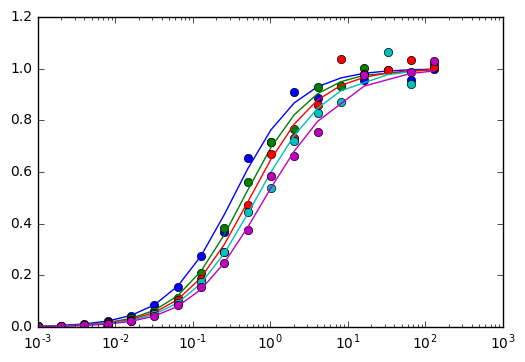

In [190]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])

In [191]:
#define an objective function for use with lmfit (must mesh with lmfit.Parameter class)
def wyman_obj_lmfit(parm,lig,data,rtot,eps=None):
    """maximizes vector ops"""
    k11 = parm['k11']
    k21 = parm['k21']
    k22 = parm['k22']
    l20 = parm['l20']
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)
    
    if eps is None:
        return residual
    else:
        weights = 1/np.square(np.concatenate(eps))
        return (residual*weights)

In [192]:
import lmfit

In [193]:
parms = lmfit.Parameters()

In [194]:
parms.add('k11', value=10., min=0.01)
parms.add('k21', value=10., min=0.01)
parms.add('k22', value=10., min=0.01)
parms.add('l20', value=100., min=0.01)

In [195]:
wym_min = lmfit.Minimizer(wyman_obj_lmfit,parms,fcn_args=(ligset,bindset_n,rtots))

In [196]:
wym_res = wym_min.minimize(method='least_squares')

In [197]:
lmfit.report_fit(wym_res)

[[Fit Statistics]]
    # function evals   = 15
    # data points      = 84
    # variables        = 4
    chi-square         = 0.064
    reduced chi-square = 0.001
    Akaike info crit   = -594.765
    Bayesian info crit = -585.042
[[Variables]]
    k11:   3.47868414 (init= 10)
    k21:   1.92103362 (init= 10)
    k22:   0.09652580 (init= 10)
    l20:   256.038635 (init= 100)
[[Correlations]] (unreported correlations are <  0.100)


In [198]:
from scipy import optimize

In [199]:
wym_res.x

array([  3.47868414e+00,   1.92103362e+00,   9.65258021e-02,
         2.56038635e+02])

In [200]:
bindset_fit = wyman_sim_parmvec(wym_res.x,ligset,rtots)

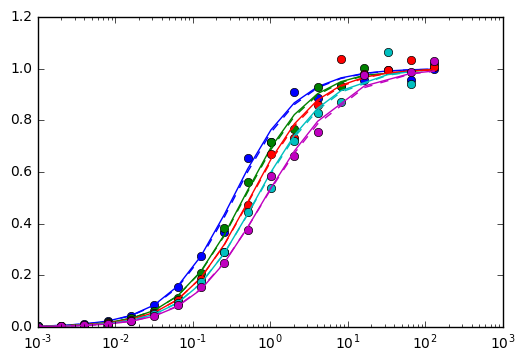

In [201]:
for i in range(bindset_n.size):
    plt.semilogx(ligset[i],bindset_n[i],'o',color=clr[i])
    plt.semilogx(ligset[i],bindset_fit[i],'--',color=clr[i])
    plt.semilogx(ligset[i],bindset[i],color=clr[i])

In [202]:
err = 0.05*bindset_n

In [203]:
err

array([ array([ 0.00014738,  0.00025343,  0.00058572,  0.00120474,  0.00212132,
        0.00414849,  0.0076586 ,  0.01373695,  0.01827465,  0.03269751,
        0.0358796 ,  0.04550262,  0.04426897,  0.04655081,  0.04779944,
        0.04967459,  0.04778803,  0.0498716 ]),
       array([ 0.00011266,  0.0002013 ,  0.0004407 ,  0.00086661,  0.00164598,
        0.00315961,  0.00561793,  0.01044396,  0.01909914,  0.02802555,
        0.03585676,  0.03833374,  0.0465011 ,  0.04671296,  0.05012622,
        0.05082818]),
       array([  9.90836713e-05,   1.81082982e-04,   3.66408623e-04,
         7.61459574e-04,   1.38819160e-03,   2.71497655e-03,
         5.16646249e-03,   9.30362149e-03,   1.45099510e-02,
         2.35649870e-02,   3.35101608e-02,   3.66207772e-02,
         4.30112491e-02,   5.18849283e-02,   4.90341385e-02,
         4.98002661e-02,   5.15672879e-02,   5.03039299e-02]),
       array([  8.03072242e-05,   1.52002124e-04,   3.10137768e-04,
         6.38243170e-04,   1.23444450e-0

In [204]:
wym_min_wts = lmfit.Minimizer(wyman_obj_lmfit,parms,fcn_args=(ligset,bindset_n,rtots,err))

In [208]:
wym_res_wts = wym_min_wts.minimize()

In [209]:
lmfit.report_fit(wym_res_wts)

[[Fit Statistics]]
    # function evals   = 57
    # data points      = 84
    # variables        = 4
    chi-square         = 465416637.065
    reduced chi-square = 5817707.963
    Akaike info crit   = 1312.321
    Bayesian info crit = 1322.044
[[Variables]]
    k11:   3.32055138 +/- 0.104682 (3.15%) (init= 10)
    k21:   1.43063734 +/- 0.077613 (5.43%) (init= 10)
    k22:   0.01000005 +/- 0.239133 (2391.33%) (init= 10)
    l20:   135.051476 +/- 22.82413 (16.90%) (init= 100)
[[Correlations]] (unreported correlations are <  0.100)
    C(k11, l20)                  =  0.939 
    C(k21, l20)                  =  0.862 
    C(k11, k21)                  =  0.665 
    C(k21, k22)                  = -0.178 


In [212]:
parmsols = np.array([10.,10.,1.,100.])

In [213]:
parmsols

array([  10.,   10.,    1.,  100.])

In [224]:
#define an objective function for use with scipy optimize (obviates parameter class)
def wyman_obj_vecmin(parm,lig,data,rtot,eps=None):
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    ligc = np.concatenate(lig)
    datac = np.concatenate(data)
    
    rfree = (((-1 - k11*ligc)) + \
    (np.sqrt(np.concatenate((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))))) \
    / (4*l20*(1 + k21*ligc + k21*k22*(np.square(ligc))))    
       
    bfrac = (k11*ligc + l20*k21*rfree*ligc + \
    2*l20*k21*k22*rfree*(np.square(ligc))) \
    / (1 + 2*l20*rfree + k11*ligc + \
    2*l20*k21*rfree*ligc + 2*l20*k21*k22*rfree*(np.square(ligc)))
    
    residual = (bfrac - datac)

    if eps is None:
        return residual
    else:
        weights = 1/np.square(np.concatenate(eps))
        return (residual*weights)

In [215]:
parmvec

[3.7, 1.8, 0.12, 293.0]

In [217]:
sim_parms

{'k11': 3.7, 'k21': 1.8, 'k22': 0.12, 'l20': 293.0}

In [219]:
sim_parms.values()

dict_values([3.7, 0.12, 1.8, 293.0])

In [238]:
res_lsq = optimize.least_squares(wyman_obj_vecmin,parmvec,args=(ligset,bindset_n,rtots))

In [239]:
res_lsq.x

array([  3.47870295e+00,   1.92104417e+00,   9.65322400e-02,
         2.56046703e+02])

In [246]:
bounds2 = ((0.,0.,0.,0.),(10.,10.,0.1,1000.))

In [247]:
bounds2

((0.0, 0.0, 0.0, 0.0), (10.0, 10.0, 0.1, 1000.0))

In [253]:
res_lsq_bound = optimize.least_squares(wyman_obj_vecmin,parmsols,bounds=((0.,0.,0.,0.),(100.,100.,100.,1000.)),args=(ligset,bindset_n,rtots))

In [254]:
res_lsq_bound.x

array([  3.47870006e+00,   1.92104253e+00,   9.65313078e-02,
         2.56045490e+02])

In [255]:
bounds3=((0.,0.,0.,0.),(100.,100.,100.,1000.))

In [256]:
parmsols

array([  10.,   10.,    1.,  100.])

In [259]:
res_lsq_bounds2 = optimize.least_squares(wyman_obj_vecmin,parmsols,bounds=bounds3,args=(ligset,bindset_n,rtots))

In [260]:
res_lsq_bounds2.x

array([  3.47870006e+00,   1.92104253e+00,   9.65313078e-02,
         2.56045490e+02])

In [261]:
wym_res.x

array([  3.47868414e+00,   1.92103362e+00,   9.65258021e-02,
         2.56038635e+02])

In [262]:
res_lsq_lm = optimize.least_squares(wyman_obj_vecmin,res_lsq_bounds2.x,method='lm',args=(ligset,bindset_n,rtots))

In [263]:
res_lsq_lm.x

array([  3.47876751e+00,   1.92108054e+00,   9.65545823e-02,
         2.56074480e+02])

In [267]:
type(-np.inf)

float

In [269]:
def lnprob_lmfit(parm,lig,data,rtot,eps=None):
    return -0.5 * np.sum((wyman_obj_lmfit(parm,lig,data,rtot,eps))**2 + np.log(np.concatenate(2 * np.pi * eps**2)))

In [281]:
mcmc2 = lmfit.Minimizer(lnprob_lmfit, wym_res.params, fcn_args=(ligset,bindset_n,rtots))

In [282]:
result_mc2 = mcmc2.emcee(burn=50, steps=500, is_weighted=False, params=wym_res.params)

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [283]:
help(lnprob_lmfit)

Help on function lnprob_lmfit in module __main__:

lnprob_lmfit(parm, lig, data, rtot, eps=None)



In [285]:
lnprob_lmfit(wym_res_wts.params,ligset,bindset_n,rtots)

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [289]:
bindset_n

array([ array([ 0.00294764,  0.00506857,  0.01171443,  0.02409477,  0.04242633,
        0.0829698 ,  0.15317205,  0.27473908,  0.36549305,  0.6539502 ,
        0.71759209,  0.91005245,  0.88537934,  0.9310163 ,  0.95598881,
        0.99349177,  0.95576054,  0.997432  ]),
       array([ 0.00225324,  0.00402609,  0.00881405,  0.01733223,  0.03291965,
        0.06319228,  0.11235852,  0.20887912,  0.38198282,  0.56051093,
        0.71713524,  0.76667476,  0.93002206,  0.93425922,  1.00252446,
        1.01656369]),
       array([ 0.00198167,  0.00362166,  0.00732817,  0.01522919,  0.02776383,
        0.05429953,  0.10332925,  0.18607243,  0.29019902,  0.47129974,
        0.67020322,  0.73241554,  0.86022498,  1.03769857,  0.98068277,
        0.99600532,  1.03134576,  1.0060786 ]),
       array([ 0.00160614,  0.00304004,  0.00620276,  0.01276486,  0.02468889,
        0.04878889,  0.09258958,  0.17495165,  0.28838219,  0.44356135,
        0.53627062,  0.71793977,  0.82754191,  0.86987028,  1

In [290]:
help(wyman_obj_vecmin)

Help on function wyman_obj_vecmin in module __main__:

wyman_obj_vecmin(parm, lig, data, rtot, eps=None)
    #define an objective function for use with scipy optimize (obviates parameter class)



In [291]:
help(wyman_obj_lmfit)

Help on function wyman_obj_lmfit in module __main__:

wyman_obj_lmfit(parm, lig, data, rtot, eps=None)
    maximizes vector ops



In [293]:
parmvec

[3.7, 1.8, 0.12, 293.0]

In [295]:
parms

Parameters([('k11', <Parameter 'k11', 10.0, bounds=[0.01:inf]>),
            ('k21', <Parameter 'k21', 10.0, bounds=[0.01:inf]>),
            ('k22', <Parameter 'k22', 10.0, bounds=[0.01:inf]>),
            ('l20', <Parameter 'l20', 100.0, bounds=[0.01:inf]>)])

In [297]:
res_lsq_lm.x

array([  3.47876751e+00,   1.92108054e+00,   9.65545823e-02,
         2.56074480e+02])

In [299]:
wym_res.params

Parameters([('k11', <Parameter 'k11', 3.4786841406531743, bounds=[0.01:inf]>),
            ('k21', <Parameter 'k21', 1.9210336218861064, bounds=[0.01:inf]>),
            ('k22',
             <Parameter 'k22', 0.096525802091210672, bounds=[0.01:inf]>),
            ('l20', <Parameter 'l20', 256.03863543193353, bounds=[0.01:inf]>)])

In [302]:
np.sum(wyman_obj_vecmin(res_lsq_lm.x,ligset,bindset_n,rtots))

-0.14888949128156076

In [304]:
np.sum(wyman_obj_lmfit(wym_res.params,ligset,bindset_n,rtots))

-0.14889237761073817